### Set Up Required Libraries

In [1]:
!pip install opencv-python pillow tensorflow numpy matplotlib

### Import Libraries 

In [ ]:
import os
import shutil
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
import random
import matplotlib.pyplot as plt
import math



### Define Directories and Mapping

In [3]:
root_dir = '/Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION'   # Change directory accordingly 
train_dir = os.path.join(root_dir, 'TRAIN')
test_dir = os.path.join(root_dir, 'TEST')

train_dir_copy = os.path.join(root_dir, 'TRAIN_COPY')
test_dir_copy = os.path.join(root_dir, 'TEST_COPY')

train_pp_dir = os.path.join(root_dir, 'TRAIN_PP') 
test_pp_dir = os.path.join(root_dir, 'TEST_PP') 

index_description_mapping = {
    0: '0_INFO_END_OF_EXP_WAY',
    1: '1_PROHIBITORY_NO_JAYWALKING',
    3: '2_PROHIBITORY_SPD_LIMIT_90',
    5: '3_WARNING_ERP',
    7: '4_INFO_U_TURN_LANE',
    8: '5_MANDATORY_SPLIT_WAY',
    9: '6_MANDATORY_STOP',
    10: '7_PROHIBITORY_SPD_LIMIT_50',
    11: '8_WARNING_CURVE_RIGHT_ALIGNMENT_MARKER',
    12: '9_INFO_ZEBRA_CROSSING',
    13: '10_INFO_RAIN_SHELTER',
    14: '11_PROHIBITORY_NO_ENTRY',
    15: '12_MANDATORY_KEEP_LEFT',
    16: '13_INFO_PARKING_AREA_FOR_MOTORCARS',
    17: '14_INFO_PEDESTRIAN_USE_CROSSING',
    20: '15_INFO_START_OF_EXP_WAY',
    21: '16_MANDATORY_GIVE_WAY',
    22: '17_PROHIBITORY_NO_VEH_OVER_HEIGHT_4.5',
    24: '18_WARNING_SLOW_SPEED',
    25: '19_WARNING_ROAD_HUMP',
    27: '20_INFO_ONE_WAY_RIGHT',
    28: '21_INFO_ONE_WAY_LEFT',
    29: '22_WARNING_SLOW_DOWN',
    30: '23_WARNING_MERGE',
    31: '24_PROHIBITORY_NO_RIGHT_TURN'
}

### Create Duplicate Folders

In [4]:
def create_duplicate_folder(original_dir, duplicate_dir):
    """Creates a duplicate of the folder."""
    if os.path.exists(duplicate_dir):
        shutil.rmtree(duplicate_dir)  # Remove existing duplicate if any
    shutil.copytree(original_dir, duplicate_dir)

print(f"Original TRAIN directory: {train_dir}")
print(f"Duplicate TRAIN directory: {train_dir_copy}")
create_duplicate_folder(train_dir, train_dir_copy)

print(f"Original TRAIN directory: {test_dir}")
print(f"Duplicate TRAIN directory: {test_dir_copy}")
create_duplicate_folder(test_dir, test_dir_copy)


Original TRAIN directory: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN
Duplicate TRAIN directory: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_COPY
Original TRAIN directory: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TEST
Duplicate TRAIN directory: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TEST_COPY


### Rename Subfolders Using Mapping

In [5]:
def rename_subfolders(directory, mapping):
    """Renames the subfolders of the given directory based on the provided mapping."""
    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            try:
                index = int(subfolder_name)  # The subfolder name is the index number
                if index in mapping:  # Only rename if the index is in the mapping
                    new_name = mapping[index]
                    new_subfolder_path = os.path.join(directory, new_name)

                    os.rename(subfolder_path, new_subfolder_path)
                    print(f"Renamed '{subfolder_name}' to '{new_name}'")
                else:
                    print(f"Skipping '{subfolder_name}' as it's not in the mapping.")
            except PermissionError:
                print(f"Permission denied: Skipping '{subfolder_name}'")
            except Exception as e:
                print(f"Error renaming '{subfolder_name}': {e}")


rename_subfolders(train_dir_copy, index_description_mapping)
rename_subfolders(test_dir_copy, index_description_mapping)



Renamed '20' to '15_INFO_START_OF_EXP_WAY'
Renamed '27' to '20_INFO_ONE_WAY_RIGHT'
Renamed '9' to '6_MANDATORY_STOP'
Renamed '0' to '0_INFO_END_OF_EXP_WAY'
Renamed '11' to '8_WARNING_CURVE_RIGHT_ALIGNMENT_MARKER'
Renamed '7' to '4_INFO_U_TURN_LANE'
Renamed '29' to '22_WARNING_SLOW_DOWN'
Renamed '16' to '13_INFO_PARKING_AREA_FOR_MOTORCARS'
Renamed '28' to '21_INFO_ONE_WAY_LEFT'
Renamed '17' to '14_INFO_PEDESTRIAN_USE_CROSSING'
Renamed '1' to '1_PROHIBITORY_NO_JAYWALKING'
Renamed '10' to '7_PROHIBITORY_SPD_LIMIT_50'
Renamed '8' to '5_MANDATORY_SPLIT_WAY'
Renamed '21' to '16_MANDATORY_GIVE_WAY'
Renamed '31' to '24_PROHIBITORY_NO_RIGHT_TURN'
Renamed '30' to '23_WARNING_MERGE'
Renamed '24' to '18_WARNING_SLOW_SPEED'
Renamed '15' to '12_MANDATORY_KEEP_LEFT'
Renamed '3' to '2_PROHIBITORY_SPD_LIMIT_90'
Renamed '12' to '9_INFO_ZEBRA_CROSSING'
Renamed '13' to '10_INFO_RAIN_SHELTER'
Renamed '5' to '3_WARNING_ERP'
Renamed '14' to '11_PROHIBITORY_NO_ENTRY'
Renamed '22' to '17_PROHIBITORY_NO_VEH_OVE

# Dataset Exploration and Visualization

## Visualizing Image Counts per Class

### Helps to identify any class imbalances by visualizing the image counts for each class in the TRAIN and TEST directories using horizontal bar plots.

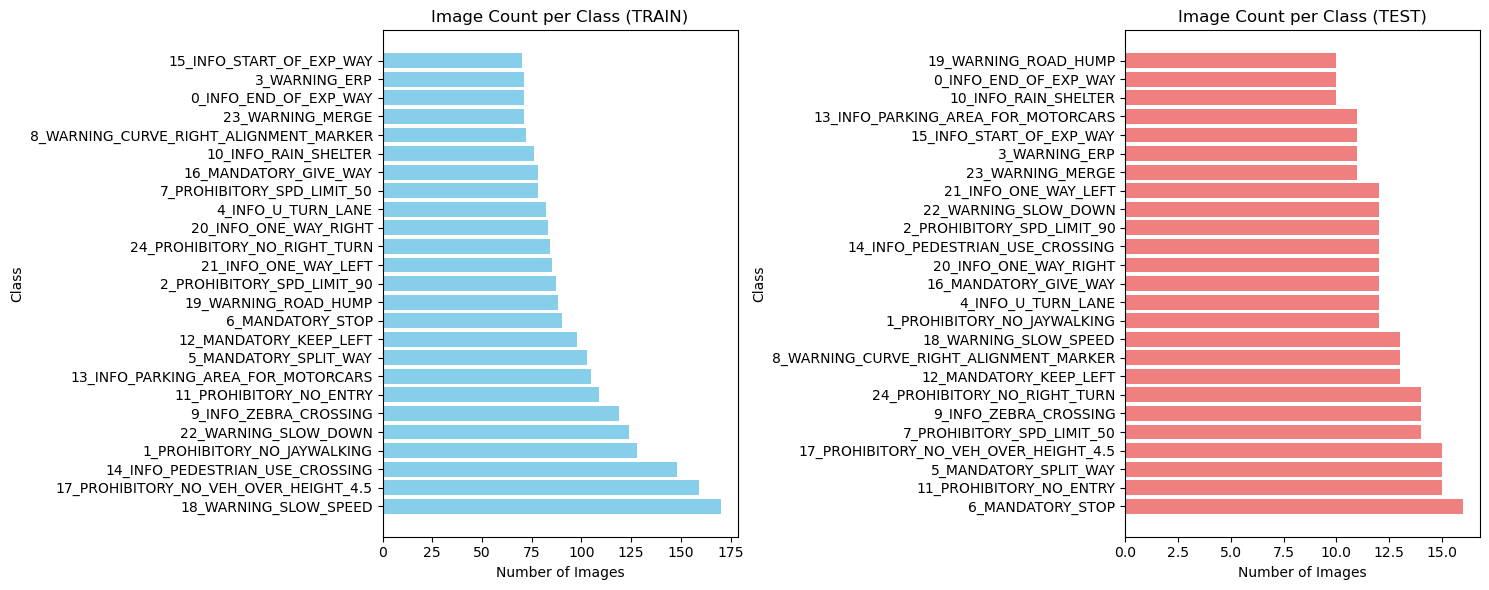

In [6]:
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):

            image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = image_count
    return class_counts

train_counts = count_images_in_classes(train_dir_copy)
test_counts = count_images_in_classes(test_dir_copy)

def plot_image_counts(train_counts, test_counts):

    train_sorted = sorted(train_counts.items(), key=lambda x: x[1], reverse=True)
    test_sorted = sorted(test_counts.items(), key=lambda x: x[1], reverse=True)

    train_classes, train_image_counts = zip(*train_sorted)
    test_classes, test_image_counts = zip(*test_sorted)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].barh(train_classes, train_image_counts, color='skyblue')
    axes[0].set_title('Image Count per Class (TRAIN)')
    axes[0].set_xlabel('Number of Images')
    axes[0].set_ylabel('Class')


    axes[1].barh(test_classes, test_image_counts, color='lightcoral')
    axes[1].set_title('Image Count per Class (TEST)')
    axes[1].set_xlabel('Number of Images')
    axes[1].set_ylabel('Class')

    plt.tight_layout()
    plt.show()

plot_image_counts(train_counts, test_counts)


##  Visualizing Images from Subfolders

### Helps in visualizing the dataset and understanding the content of each class.

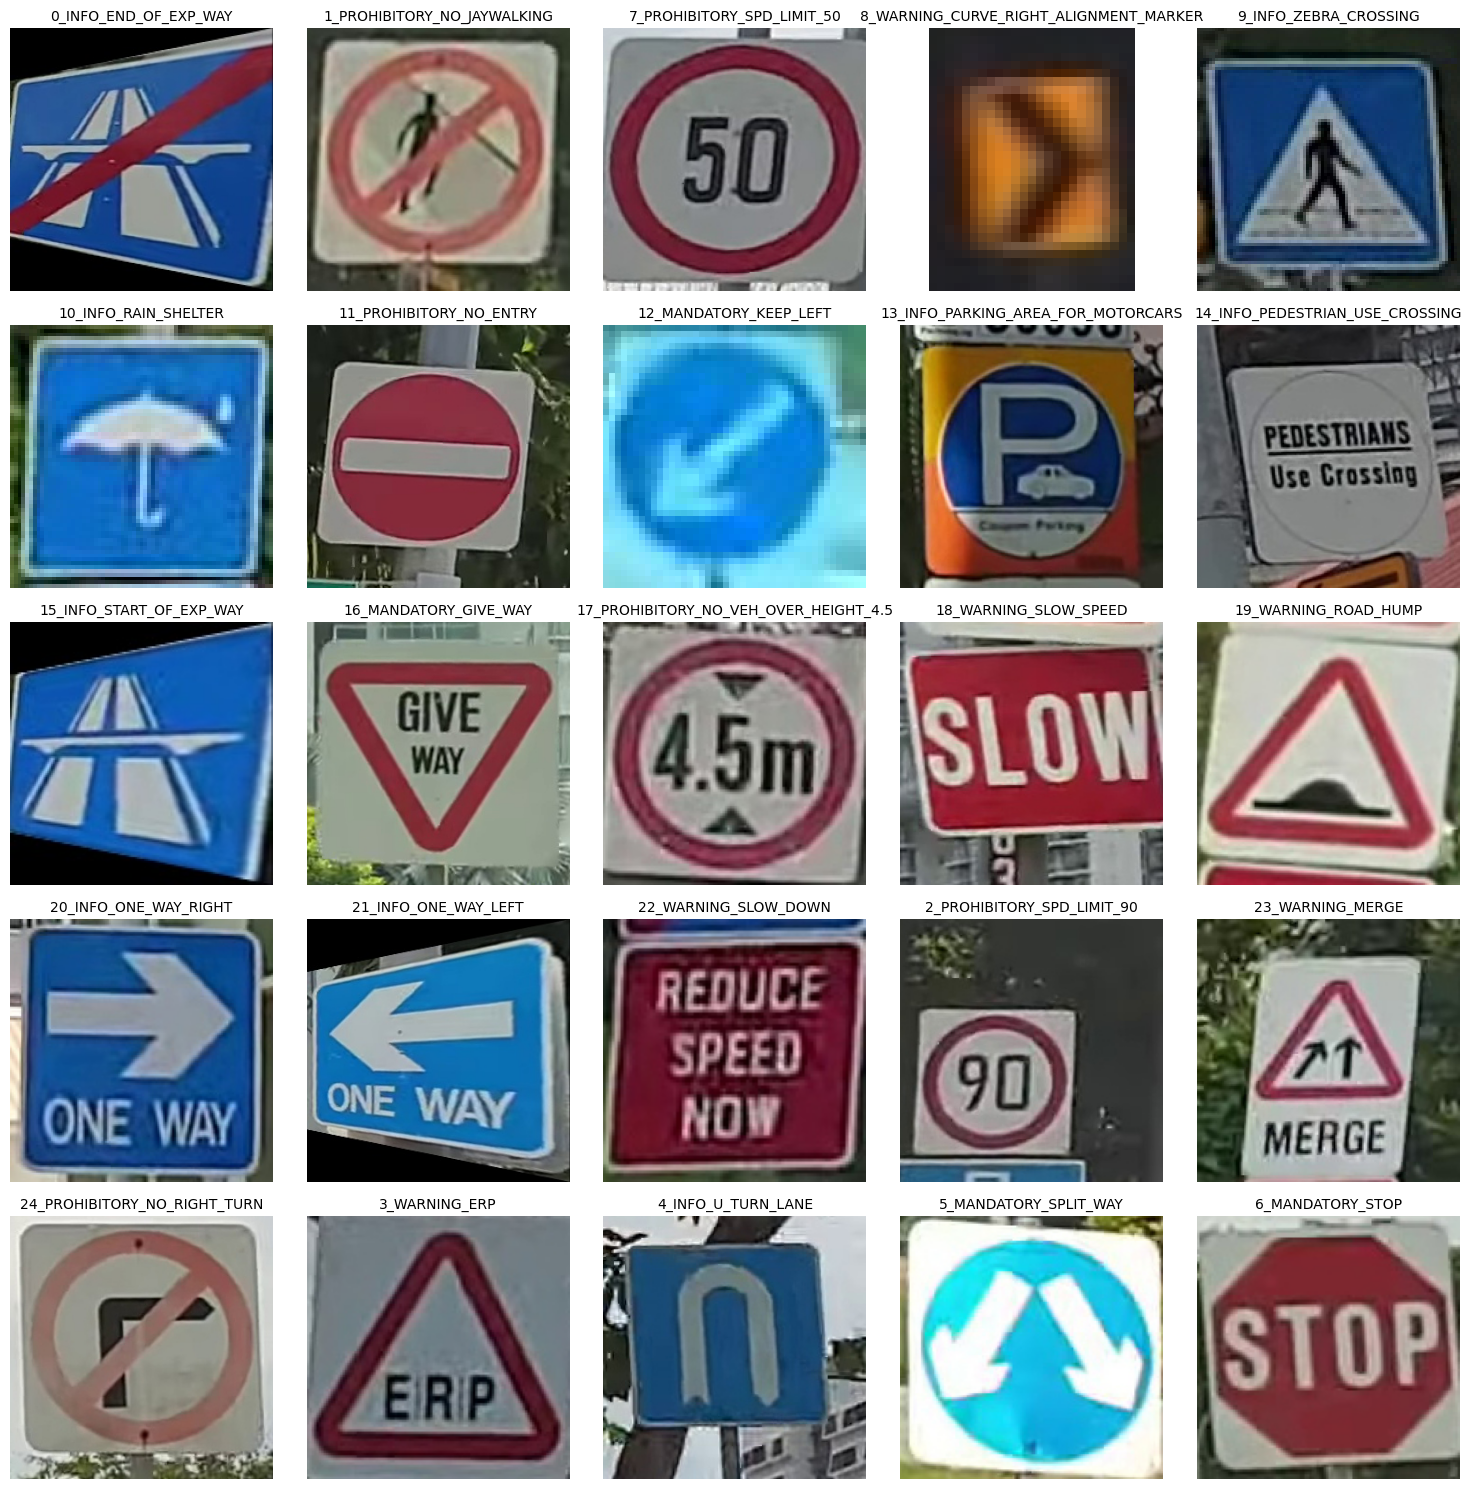

In [ ]:
def visualize_images_from_subfolders_with_mapping(directory, index_description_mapping, images_per_row=5):
    
    class_names = [d for d in sorted(os.listdir(directory)) if os.path.isdir(os.path.join(directory, d))]
    image_paths = []
    labels = []
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) > 0:

            img_path = os.path.join(class_path, image_files[0])
            image_paths.append(img_path)

            class_index = int(class_name) 
            if class_index in index_description_mapping:
                labels.append(index_description_mapping[class_index])
            else:
                labels.append(f"Unknown Class {class_name}")  
    
    num_images = len(image_paths)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3))
    
    axes = axes.flatten()
    
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off') 
        axes[i].set_title(labels[i], fontsize=10) 
    

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
visualize_images_from_subfolders_with_mapping(train_dir, index_description_mapping, images_per_row=5)


#  Image Preprocessing

## Convert Image to 8 bit

### Ensure the image is in the correct format (CV_8U) for OpenCV operations

In [8]:
def convert_to_8bit(image):
    if image.dtype != np.uint8:
        image = np.uint8(image)
    return image

## Normalize Image

### Normalizes image pixel values to the range [-1, 1] for better performance.


In [9]:
def normalize_image(image):
    return (image / 127.5) - 1 

## Create Mask for Image

### Creates a binary mask to isolate specific regions based on color in the HSV color space.


In [10]:
def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([0, 0, 250])
    upper_hsv = np.array([250, 255, 255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

## Resize Image

### Resizes the image to a fixed size (e.g., 224x224) to match model input requirements.


In [11]:
def resize_image(image, size=(224, 224)):
    resized_image = cv2.resize(image, size)
    return resized_image

## Gray Image

### Converts the image to grayscale, reducing complexity by removing color information.

In [12]:
def gray_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) 

## Threshold Image

### Converts the image to a binary format, separating foreground and background.

In [13]:
def thresh_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  
    return cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)  

## Remove Noise (Gaussian Blur)

### Applies Gaussian blur to reduce high-frequency noise and smooth the image.

In [14]:
def rnoise_image(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

## Dilate Image

### Expands white regions in a binary image to highlight features or connect fragmented areas.

In [15]:
def dilate_image(image):
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(image, kernel, iterations=1)
    return dilated

## Erode Image

### Shrinks white regions in a binary image to remove small noise or irrelevant features.

In [16]:
def erode_image(image):
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=1)
    return eroded

## Opening Image

### Combines erosion and dilation to remove small noise and preserve important features.

In [17]:
def opening_image(image):
    kernel = np.ones((5, 5), np.uint8)
    opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opened

## Median Filter

### Reduces salt-and-pepper noise by replacing each pixel with the median of its neighbors.

In [18]:
def median_filter(image):
    kernel_size = 5
    median_filtered_image = cv2.medianBlur(image, kernel_size)
    return median_filtered_image

## Bilateral Filter

### Smooths the image while preserving edges, useful for noise reduction without blurring features.

In [19]:
def bilateral_filter(image):
    d = 9
    sigma_color = 75
    sigma_space = 75
    bilateral_filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    return bilateral_filtered_image


## Canny Edge Detection

### Detects edges in the image to highlight boundaries and contours of objects.

In [20]:
def canny_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

## Sharpen Image

### Enhances edges and details in the image to make features more prominent.

In [21]:
def sharpen_image(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])  
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

## Load Random Images

### Fetches a random selection of images from a directory for processing to visualize different images from the dataset.

In [29]:
def load_random_images(directory, num_images=5):
    all_images = []
    image_paths = []
    
    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, filename)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
    
    random_paths = random.sample(image_paths, num_images)
    
    for path in random_paths:
        img = cv2.imread(path)
        all_images.append(img)
    
    return all_images, random_paths


original_images, image_paths = load_random_images(train_dir_copy)
labels = [path.split("/")[-2] for path in image_paths]

## Display Preprocessing Steps

### Visualizes the original and preprocessed images for comparison, helping to observe the impact of different transformations.

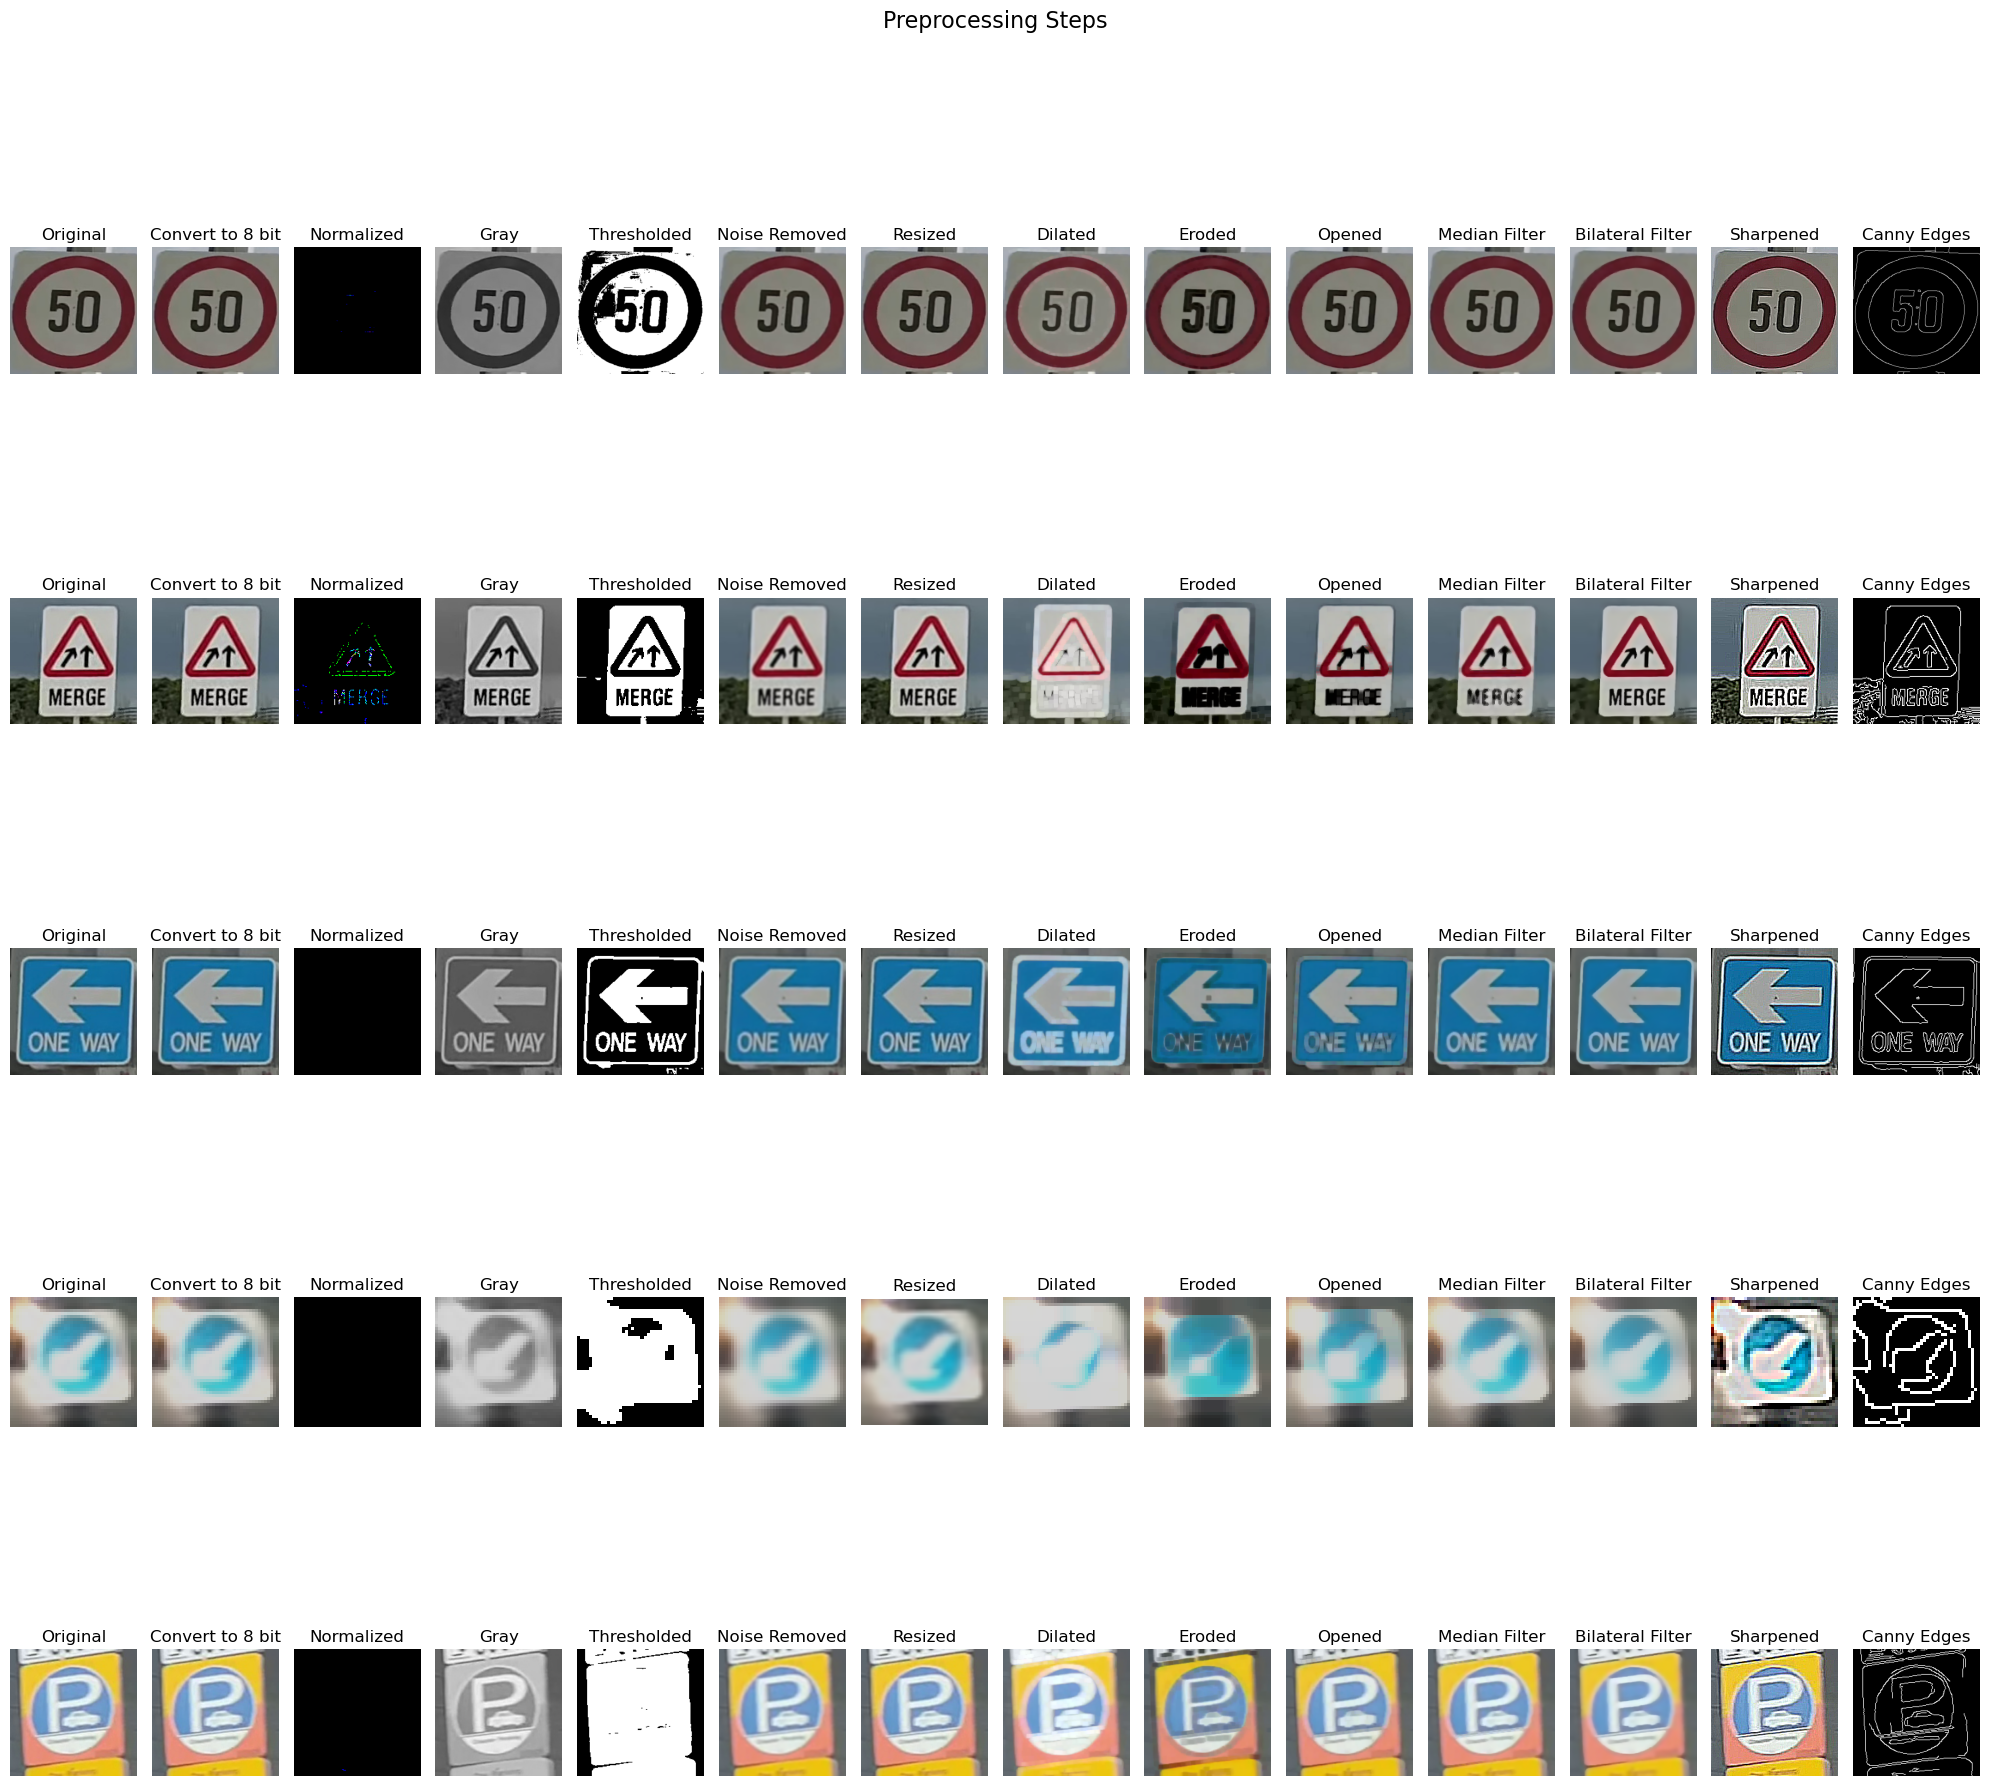

In [30]:
preprocessing_funcs = [
    ("Original", lambda x: x),
    ("Convert to 8 bit", convert_to_8bit),
    ("Normalized", normalize_image),
    ("Gray", gray_image),
    ("Thresholded", thresh_image),
    ("Noise Removed", rnoise_image),
    ("Resized", resize_image),
    ("Dilated", dilate_image),
    ("Eroded", erode_image),
    ("Opened", opening_image),
    ("Median Filter", median_filter),
    ("Bilateral Filter", bilateral_filter),
    ("Sharpened", sharpen_image),
    ("Canny Edges", canny_image),
]

def display_preprocessing_steps(original_images, preprocessing_funcs, labels, num_images=5):
    fig, axes = plt.subplots(num_images, len(preprocessing_funcs), figsize=(20, 20))
    fig.suptitle('Preprocessing Steps', fontsize=16)
    
    indices = random.sample(range(len(original_images)), num_images)
    
    for i, idx in enumerate(indices):
        original = original_images[idx]
        axes[i, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f"Original - {labels[idx]}")
        axes[i, 0].axis('off')
        
        for j, (title, func) in enumerate(preprocessing_funcs):
            processed_image = func(original)
            processed_image = convert_to_8bit(processed_image)
        
            if len(processed_image.shape) == 2:
                axes[i, j].imshow(processed_image, cmap='gray')
            else:
                axes[i, j].imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
            
            axes[i, j].set_title(title)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


display_preprocessing_steps(
    original_images=original_images, 
    preprocessing_funcs=preprocessing_funcs,
    labels=labels, 
    num_images=5
)


## Saving preprocessed images

In [24]:
first_preprocessing_funcs = [
    ("Original", lambda x: x),
    ("Convert to 8 bit", convert_to_8bit),
    ("Noise Removed", rnoise_image),
    ("Resized", resize_image),
    ("Dilated", dilate_image),
    ("Eroded", erode_image),
    ("Opened", opening_image),
    ("Median Filter", median_filter),
    ("Bilateral Filter", bilateral_filter),
    ("Sharpened", sharpen_image),
]


def preprocess_image(image, preprocessing_funcs):
    if len(image.shape) == 2:  
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  

    if image.dtype != np.uint8:
        image = np.uint8(image)
    
    for title, func in preprocessing_funcs:
        prev_shape = image.shape
        image = func(image)  

        if image.dtype != np.uint8:
            image = np.uint8(image)
    
    if len(image.shape) == 2:  
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    return image

def preprocess_and_save_all_images(dir, preprocessing_funcs, save_dir):

    for subfolder_name in os.listdir(dir):
        subfolder_path = os.path.join(dir, subfolder_name)
        
        if os.path.isdir(subfolder_path):
            save_subfolder = os.path.join(save_dir, subfolder_name)
            if not os.path.exists(save_subfolder):
                os.makedirs(save_subfolder)

            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)
                
                if os.path.isfile(image_path):
                    image = cv2.imread(image_path)
                    if image is not None:
                        processed_image = preprocess_image(image, preprocessing_funcs)

                        if processed_image is not None and processed_image.any():
                            processed_image_path = os.path.join(save_subfolder, image_name)
                            cv2.imwrite(processed_image_path, processed_image)
                            print(f"Processed image saved: {processed_image_path}")
                        else:
                            print(f"Warning: Processed image is empty, not saving: {image_name}")
                    else:
                        print(f"Warning: Failed to read image {image_path}")
                else:
                    print(f"Skipping non-file {image_path}")

preprocess_and_save_all_images(dir=train_dir_copy, preprocessing_funcs=first_preprocessing_funcs, save_dir=train_pp_dir)
preprocess_and_save_all_images(dir=test_dir_copy, preprocessing_funcs=first_preprocessing_funcs, save_dir=test_pp_dir)


Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/5479.jpg
Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/5492.jpg
Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/5486.jpg
Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/5914.jpg
Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/1554.jpg
Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/5524.jpg
Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/6011.jpg
Processed image saved: /Users/ramita/Desktop/SINGAPORE_TRAFFIC_SIGNS_CLASSIFICATION/TRAIN_PP/10_INFO_RAIN_SHELTER/5487.jpg
Processed image 